In [1]:
from sec_certs.dataset import CCDataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
# TODO:
# - Cryptographic primitives

In [3]:
dset = CCDataset.from_json("/Users/adam/phd/projects/certificates/sec-certs/datasets/new_cc/cc_dset.json")  # local instantiation
# dset = CCDataset.from_web_latest()  # remote instantiation

df = dset.to_pandas()

## Category distribution over time

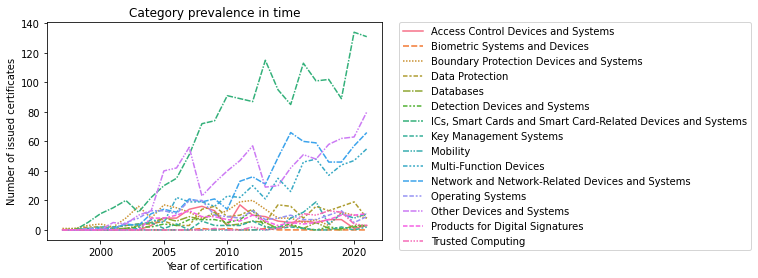

In [4]:
pivot = df.loc[df.year_from < 2022].groupby(["year_from", "category"], as_index=False).size().rename(columns={"size": "frequency"}).pivot("year_from", "category", "frequency").fillna(0)
sns.lineplot(data=pivot)
plt.xlabel("Year of certification")
plt.ylabel("Number of issued certificates")
plt.legend(title="Category")
plt.title("Category prevalence in time")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Security level distribution over time

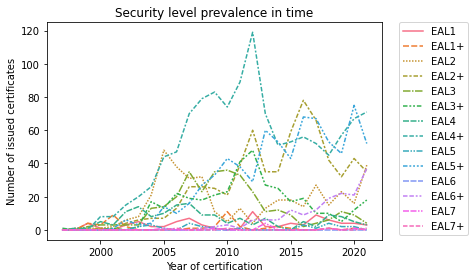

In [5]:
pivot = df.loc[df.year_from < 2022].groupby(["year_from", "eal"], as_index=False).size().rename(columns={"size": "frequency"}).pivot("year_from", "eal", "frequency").fillna(0)
sns.lineplot(data=pivot)
plt.xlabel("Year of certification")
plt.ylabel("Number of issued certificates")
plt.legend(title="Security level")
plt.title("Security level prevalence in time")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Average security level over time

- Quantify security level as number from 0 (EAL1) to 13 (EAL7+)
- Show three plots:
    1. lineplot of average security level over time
    2. scatter plot of average security level over time, where size of dot is weighted by the number of certificates issued in the given year
    3. Show fitted line plot of average security level over time
- Year 1999 is a clear outlier, print its certificates 

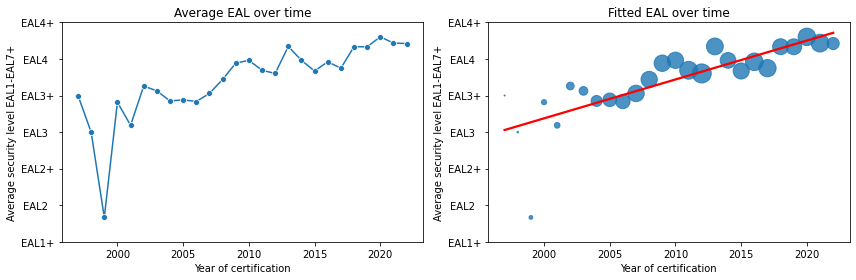

                                                               name  \
dgst                                                                  
ed0b7793ac82822e              DragonFly Companion, V3.02, Build 129   
b4da176e90013e7c                ConSeal Private Desktop Version 1.4   
cf17802c4a3a9b46                           VCS Firewall Version 3.0   
b7e41112ca4365db                    SecureDoc Disk Encryption v 2.0   
edf5e07d81d2a821                             TrueDelete Version 4.0   
f06c9e51d8958828          Philips Smart Card Controller P8WE5032V0B   
4b115ca54a6c9b24  'Mondex Purse 2' electronic purse version 0203...   
bc2cec6771b2db7a  B4/B0' V2 bank application of the MONEO/CB hyb...   
4abdd835c7f81232  Javacard/VOP GemXpresso 211 platform (Philips ...   
175fb27ed3f07cc5  MONEO electronic wallet card carrier (ST19SF16...   
950f88c6036241af  Entrust/Admin & Entrust/Authority from Entrust...   
0c76c4cdbb8ee42d     B1/EST-X Version 2.0.1 with AIX, Version 4.3.1   

     

In [6]:
eal_to_num_mapping = {eal: index for index, eal in enumerate(df['eal'].cat.categories)}
df["eal_number"] = df.eal.map(eal_to_num_mapping)
df.eal_number = df.eal_number.astype("Int64")
avg_levels = df.loc[df.eal_number.notnull()].copy().groupby(["year_from"]).agg({'year_from':'size', 'eal_number':'mean'}).rename(columns={"year_from": "n_certs"}).reset_index()
avg_levels.year_from = avg_levels.year_from.astype("float")
avg_levels.eal_number = avg_levels.eal_number.astype("float")

ymin = math.floor(avg_levels.eal_number.min())
ymax = math.ceil(avg_levels.eal_number.max())
ylabels = [x if "+" in x else x + "  " for x in list(eal_to_num_mapping.keys())[ymin:ymax+1]] # this also aligns the labels by adding phantom spaces

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(12, 4)
figure.set_tight_layout(True)

line = sns.lineplot(data=avg_levels, x="year_from", y="eal_number", marker='o', ax=axes[0])
line.set(xlabel="Year of certification", ylabel="Average security level EAL1-EAL7+", title="Average EAL over time")
line.set_yticks(range(ymin, ymax+1), ylabels)

fitted = sns.regplot(data=avg_levels, x="year_from", y="eal_number", scatter_kws={"sizes": [1.2 * x for x in list(avg_levels.n_certs)]}, line_kws={"color": "red"}, ci=None, ax=axes[1])
fitted.set(xlabel="Year of certification", ylabel="Average security level EAL1-EAL7+", title="Fitted EAL over time")
fitted.set_yticks(range(ymin, ymax+1), ylabels)

plt.show()

print(df.loc[(df.eal.notnull()) & (df.year_from == 1999), ["name", "category", "eal"]])

## Average certificate lifetime

Examine average certificate lifetime. Note that approx. 1k certificates expired on a single day, at 2019-09-01.
It may be benefitial to display these plots without these certificates

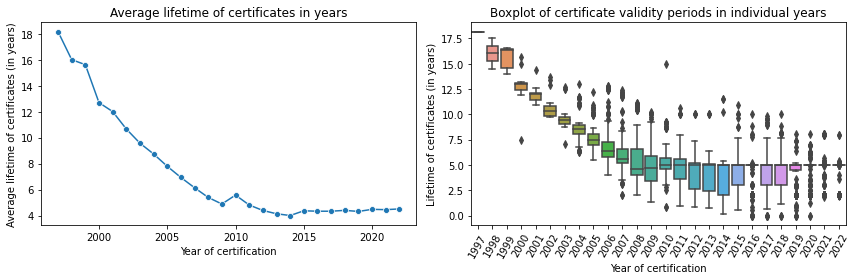

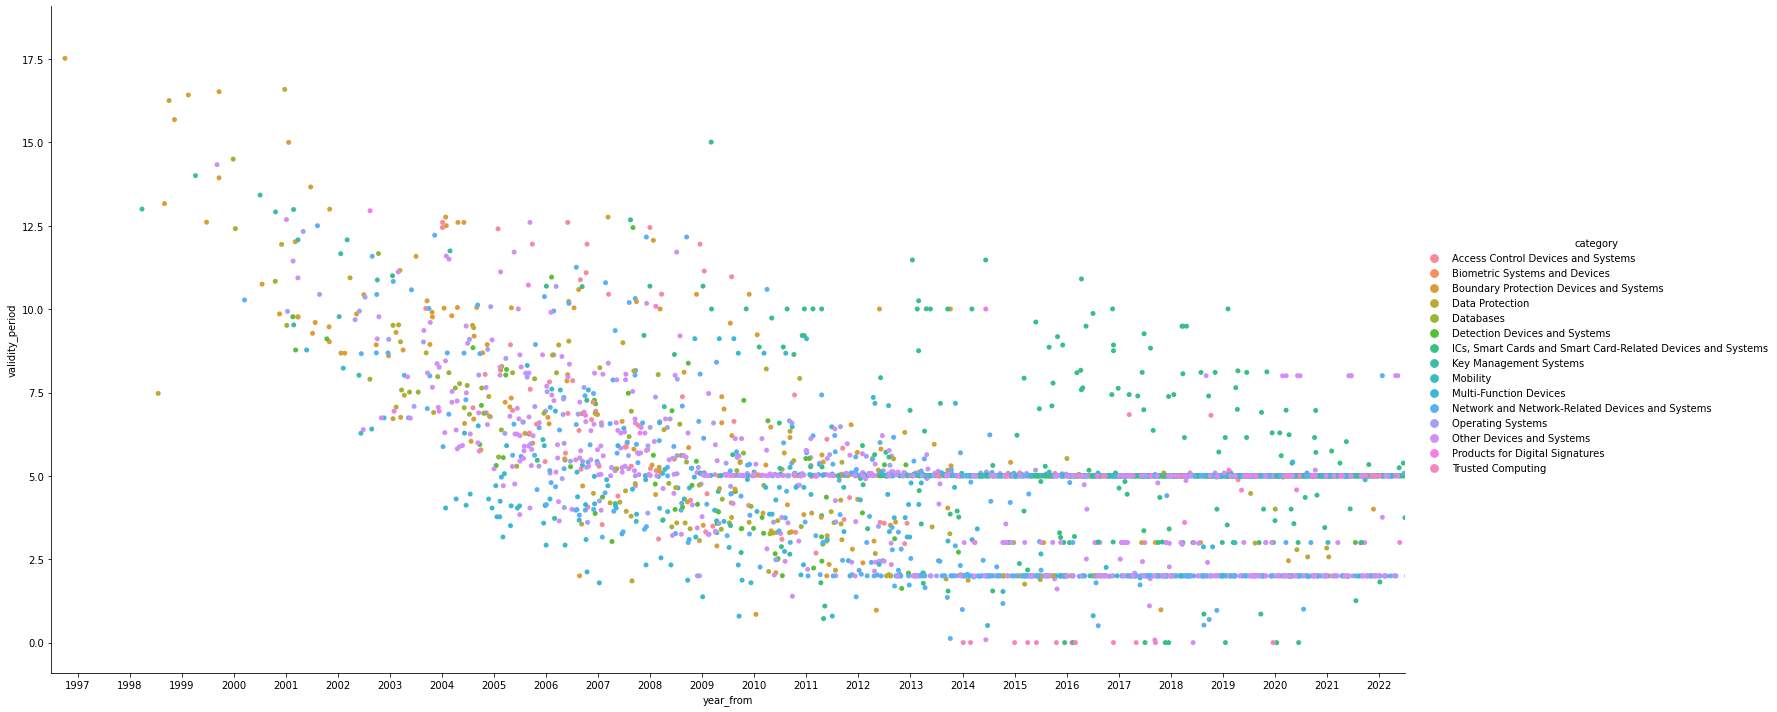

In [7]:
df["validity_period"] = (df.not_valid_after - df.not_valid_before).dt.days / 365
df_validity = df.loc[(df.validity_period.notnull()) & (df.not_valid_after != "2019-09-01")] # Alternatively add condition `& (df.not_valid_after != "2019-09-01")` to filter bulk-expired certificates.
validity_period = df_validity.groupby("year_from").agg({'year_from':'size', 'validity_period':'mean'}).rename(columns={"year_from": "n_certs"}).reset_index()

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(12, 4)
figure.set_tight_layout(True)

line = sns.lineplot(data=validity_period, x="year_from", y="validity_period", marker="o", ax=axes[0])
line.set(xlabel="Year of certification", ylabel="Average lifetime of certificates (in years)", title="Average lifetime of certificates in years")

box = sns.boxplot(data=df_validity, x="year_from", y="validity_period", ax=axes[1])
box.set(xlabel="Year of certification", ylabel="Lifetime of certificates (in years)", title="Boxplot of certificate validity periods in individual years")
box.tick_params(axis='x', rotation=60)

strips = sns.catplot(kind="strip", data=df_validity, x="year_from", y="validity_period", jitter=2, height=10, aspect=2/1, hue="category")

## Certification scheme & certification laboratory popularity over time

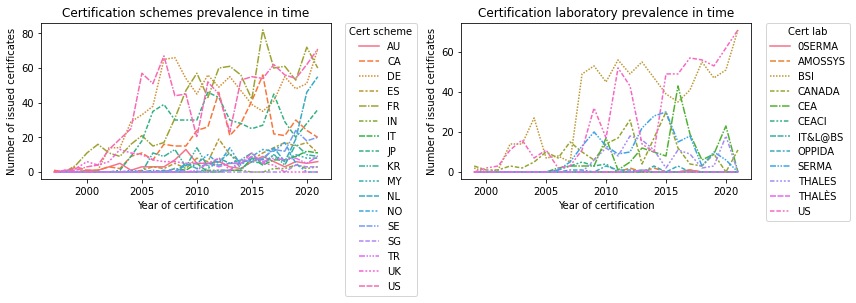

In [15]:
figure, axes = plt.subplots(1, 2)
figure.set_size_inches(12, 4)
figure.set_tight_layout(True)

schemes = df.loc[(df.scheme.notnull()) & (df.year_from < 2022)].groupby(["year_from", "scheme"], as_index=False).size().rename(columns={"size": "frequency"}).pivot("year_from", "scheme", "frequency").fillna(0)
line = sns.lineplot(data=schemes, ax=axes[0])
line.set(xlabel="Year of certification", ylabel="Number of issued certificates", title="Certification schemes prevalence in time")
line.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cert scheme")

labs = df.loc[(df.cert_lab.notnull()) & (df.year_from < 2022)].groupby(["year_from", "cert_lab"], as_index=False).size().rename(columns={"size": "frequency"}).pivot("year_from", "cert_lab", "frequency").fillna(0)
line = sns.lineplot(data=labs, ax=axes[1])
line.set(xlabel="Year of certification", ylabel="Number of issued certificates", title="Certification laboratory prevalence in time")
line.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cert lab")